In [2]:
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
from imblearn.pipeline import Pipeline
import os
import numpy as np
import matplotlib.pyplot as plt
NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


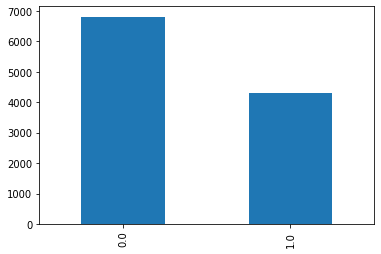

In [3]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [111]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [112]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

In [113]:
X = data.drop('episodeDispositionCode', axis=1)
y = data['episodeDispositionCode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())

In [114]:
# No need: data is fairly balanced
#smt = ADASYN(random_state=0)
#X_train, y_train = smt.fit_resample(X_train, y_train)

# No need: we use tree based method
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)

In [138]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train,y_train) 
y_val_pred_dummy = dummy_clf.predict(X_valid)
y_pred_dummy = dummy_clf.predict(X_test) 


#clf = lgbm.LGBMClassifier(is_unbalance=True).fit(X_train,y_train) #altalab search used to find best pipline
clf = lgbm.LGBMClassifier(random_state=33,learning_rate=0.1, early_stopping_rounds = 10, n_estimators=10000)
clf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=False)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
y_val_pred = clf.predict(X_valid)
y_val_probs = clf.predict_proba(X_valid)[:,1]

In [142]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

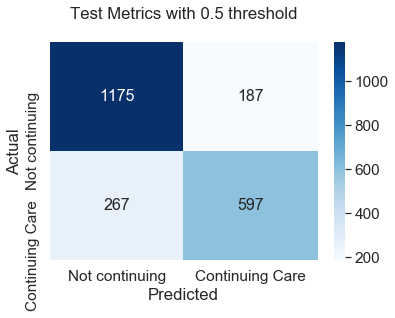

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.814840,0.761480
Recall,0.862702,0.690972
F,0.838088,0.724515
Support,1362.000000,864.000000


In [143]:
plt.title('Test Metrics with 0.5 threshold\n')
get_metrics(y_test, y_pred)

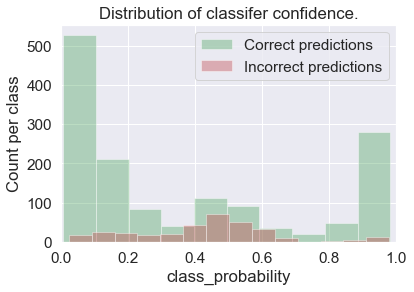

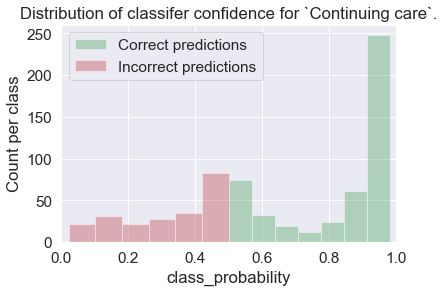

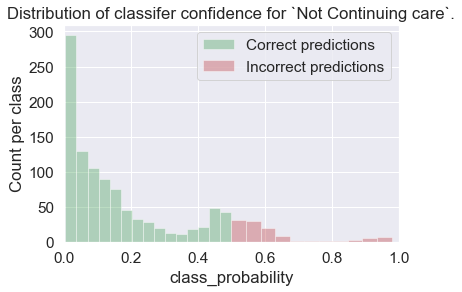

In [144]:
import seaborn as sns

pos_probas = y_val_probs[(y_valid == y_val_pred)]
neg_probas = y_val_probs[(y_valid != y_val_pred)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence.")
plt.legend()
plt.show()


mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 1)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 1)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False, label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Continuing care`.")
plt.legend()
plt.show()
mod_y_prob = 0.5
pos_probas = y_val_probs[(y_valid == y_val_pred) & (y_valid == 0)]
neg_probas = y_val_probs[(y_valid != y_val_pred)& (y_valid == 0)]
fig, ax = plt.subplots(1, 1)
sns.distplot(pos_probas, ax=ax,hist = True, kde = False,  label='Correct predictions', color = 'g', norm_hist=False)
sns.distplot(neg_probas, ax=ax,hist = True, kde = False,  label='Incorrect predictions', color = 'r', norm_hist=False)
ax.set_xlim((0, 1))
plt.ylabel('Count per class')
plt.xlabel('class_probability')
plt.title("Distribution of classifer confidence for `Not Continuing care`.")
plt.legend()
plt.show()

We see that for 

## Explaining the decision
We use a method called SHAP (SHapley Additive exPlanations). 
This plot is made of all the points in the validation data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

The explanations of why the model performed the way it did on the test set is as follows.

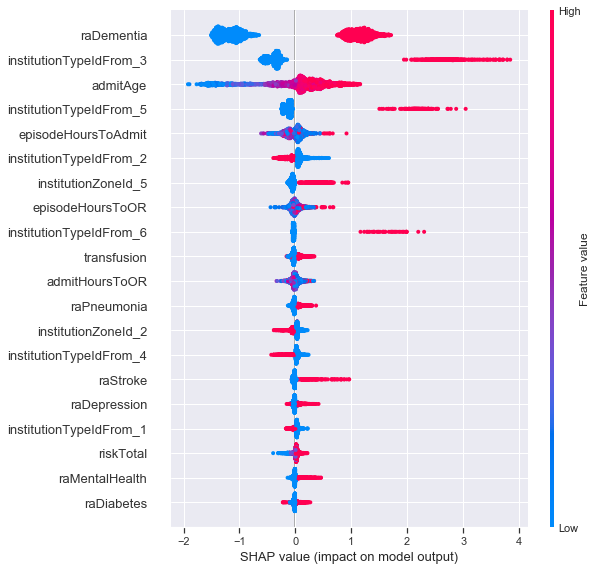

In [145]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns = feat_names ))
shap.summary_plot(shap_values[1], pd.DataFrame(X_test, columns = feat_names ))

- From the SHAP plot above, we can see that the most siginficant effect comes from`raDementia`. Larger values of the feature pushes the model to categorize the patient more to Continuing care. 
- Similarly `admitAge` pushes the model to categorize the patient more to Continuing care. 
- `institutionTypeIdFrom` plays a major role as well. We see that if the patient is coming from `institutionTypeIdFrom` 3 or 5, the patient is likely to be predicted as needing contiuing care. 
- If the patient is coming from `institutionTypeIdFrom` 2,1,4, the patient is likely to be predicted as needing contiuing care. 
- There is a weak effect of `episodeHoursToAdmit`. This is not clear but large values seem to push the model to recommend continuing care. 
- A similar effect is, if `institutionZoneId` is 5 (North), the model is recommending continuing care.  


# Effect of removing uncertain predictions
To test if removing uncertain predictions can help improve the performance of the classifier, we select two thresholds (`th1` and `th2`) that sweep across the range of probability values of the classifer and pick the ones that maximizes the F score. Anything with a probability between the two thresholds will be considered as uncertain. 

In [336]:
# Define costomized cost function

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    
#     loss = np.zeros(residual.shape)
#     loss[residual < 0] = C_p
#     loss[residual > 0] = C_n
    
    return np.mean(loss)

In [147]:
# Define custom objective function -- Weighted MSE



# def custom_asymmetric_objective_lgb(y_true, y_pred,C_p,C_n):
#     residual = (y_true - y_pred).astype("float")
#     print('\n Residule\t',residual[-10:])
#     grad = np.where(residual<=0, -2*C_p*residual, -2*C_n*residual)
#     print('\n Gradient\t',grad[-10:])
#     hess = np.where(residual<=0, 2*C_p, 2*C_n)
#     return grad, hess

# def custom_asymmetric_eval_lgb(y_true, y_pred,C_p,C_n):
#     residual = (y_true - y_pred).astype("float")
#     loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
#     #loss = np.zeros(residual.shape)
#     #loss[residual < 0] = 1.6
#     #loss[residual > 0] = 1
#     #print('\n Loss\t',loss)

#     return "custom_asymmetric_eval", np.mean(loss), False

In [361]:
# Define custom objective function -- Weighted Logistic Regression
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.misc import derivative

def weighted_loss_lgb_sk(y_true, y_pred, c_p, c_n):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray array with the predictions
    dtrain: lightgbm.Dataset
    c_p, c_n: float
    """
    def fl(x,t):
        #p = 1/(1+np.exp(-x))
        p = 1/(1+np.exp(-(x-.5)*2))
        #print(x)
        #print(p)
        return - ( c_n*t*np.log(p)+c_p*(1-t)*np.log(1-p) )

    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

#     def fl(x,t):
#         #p = 1/(1+np.exp(-x))
#         p = 1/(1+np.exp(-(x-.5)*2))
#         p_prime = 2*p**2
#         p_double_prime = 4*p* p_prime
#         return - ( c_n*t*np.log(p)+c_p*(1-t)*np.log(1-p) ),p, p_prime,p_double_prime
    
#     partial_fl, p, dp, ddp =  fl(y_pred, y_true)
#     print(y_pred)
#     grad = (-c_n*y_true/p+c_p*(1-y_true)/(1-p))*dp
#     hess = (c_n*y_true/(p**2) + c_p*(1-y_true)/((1-p)**2))*dp**2 + (grad/dp)*ddp
#     return grad, hess


def weighted_loss_lgb_eval_error_sk(y_true, y_pred, c_p, c_n):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
     c_p, c_n: float
    """
 
    #p = 1/(1+np.exp(-y_pred))
    p = 1/(1+np.exp(-(y_pred-0.5)*2))
    loss = - ( c_n* y_true*np.log(p)+c_p*(1-y_true)*np.log(1-p) )
    return 'weighted_loss', np.mean(loss), False


In [1]:
# Repredict y_pred_2

# make new model on new value
# Define weights here

c_p=5
c_n=4

weighted_loss = lambda x,y: weighted_loss_lgb_sk(x, y, c_p, c_n)
eval_error = lambda x,y: weighted_loss_lgb_eval_error_sk(x, y, c_p, c_n)


clf_direct = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= weighted_loss)

#clf_direct = lgbm.LGBMClassifier()
#clf_direct.set_params(**{'objective': weighted_loss})

clf_direct.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error,
    verbose=False,
)



y_pred_2 = clf_direct.predict(X_test)
y_prob_2 = clf_direct.predict_proba(X_test)[:,1]
y_val_pred_2 = clf_direct.predict(X_valid)
y_val_probs_2 = clf_direct.predict_proba(X_valid)[:,1]




NameError: name 'lgbm' is not defined

In [363]:
Cost(y_val_pred_2, y_valid, c_p, c_n)

0.8264044943820225

                <----------Classifer output (probability)--------->
                 
|-------------------------------------*---------------------------------------------|
0   'Not continuing care'           theta        'Continuing care'                  1

In [364]:
# mimic what's been done but only use one decision thredhold
y_pred_3 = np.ones(y_valid.shape)
cmin = 999999
pmax = 0

for theta in np.linspace(0,1,10):

    y_pred_3 = np.ones(y_valid.shape)
    y_pred_3[y_val_probs <= theta] = 0
    y_pred_3[y_val_probs > theta] = 1
   
    # Confusion metrix for each thredhold
    cm = confusion_matrix(y_valid, y_pred_3)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
 

    class_names =  [ 'Continuing Care'] 
    metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_3, average='binary') )
        
    #print(metrics,'\n')        
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    cost_to_be_mimimized = Cost(y_pred_3, y_valid, c_p, c_n)
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: F score = {np.around(var_to_be_maximized,2)}")
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: cost = {np.around(Cost(y_pred_3, y_valid, c_p, c_n),2)}")
    
    
    # Track the best decision thredhold
    if cmin > (cost_to_be_mimimized):
        cmin = (cost_to_be_mimimized)
        pmax = theta
print(f'\n Best cutoffs cost = {np.around(cmin,3)} for Not continuing care <{np.around(pmax,2)},  and continuing care >{np.around(pmax,2)}')





 Best cutoffs cost = 0.822 for Not continuing care <0.67,  and continuing care >0.67


In [365]:
# Compare costs on test set


print('\nCost for false positive is ',c_p,' unit time\t',"Cost for false negative is ",c_n,' unit time')
print('Average cost of misclassification using the following models are\n')
print('Basedline model:\t\t',np.round(Cost(y_pred_dummy, y_test, c_p, c_n),4),' unit time')
print('Default model:\t\t\t',np.round(Cost(y_pred, y_test, c_p, c_n),4),' unit time')


y_pred_test = np.ones(y_test.shape)
y_pred_test[y_prob <= pmax] = 0
print('Changing thredhold method:\t',np.round(Cost(y_pred_test, y_test, c_p, c_n),4),' unit time')
#y_pred_2_modified = np.where(y_pred_2<=0.5, 0, 1)
print('Directly optimized model:\t',np.round(Cost(y_pred_2, y_test, c_p, c_n),4),' unit time')

print('\n On average, the directly optimized model has',np.round(Cost(y_pred_2, y_test, c_p, c_n)/Cost(y_pred_dummy, y_test, c_p, c_n),2) ,'delay of the baseline model')


Cost for false positive is  5  unit time	 Cost for false negative is  4  unit time
Average cost of misclassification using the following models are

Basedline model:		 1.5526  unit time
Default model:			 0.8998  unit time
Changing thredhold method:	 0.8868  unit time
Directly optimized model:	 0.8522  unit time

 On average, the directly optimized model has 0.55 delay of the baseline model


In [366]:
metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
#df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
# df_cm.index.name = 'Class'
# df_cm.columns.name = 'Metrics'
# display(df_cm)
print(metrics)

[[8.14840499e-01 7.61479592e-01]
 [8.62701909e-01 6.90972222e-01]
 [8.38088445e-01 7.24514563e-01]
 [1.36200000e+03 8.64000000e+02]]


We see that including any prediction in undertain class reduces the performance of the algorithm.

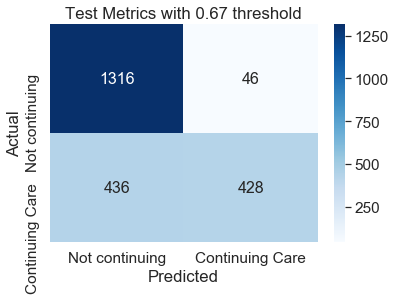

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.751142,0.902954
Recall,0.966226,0.495370
F,0.845215,0.639761
Support,1362.000000,864.000000


In [367]:
plt.title(f'Test Metrics with {np.around(pmax,2)} threshold')
get_metrics(y_test, y_prob>pmax)

We see that with further tuning performance of the classifier can be improved. 

## Test of reliability
To test if the classifer can maintain performance we create 10 random splits of the data in the training-test set and then repeat the process of evaluating the algorithm.

In [19]:
clf_not_tuned =  lgbm.LGBMClassifier() 
pipeline = Pipeline([('oversample', smt), ('scale', scaler), ('classifer', clf_not_tuned)])
metrics = []
means = []
standard_devs = []
for metric in [ 'recall','precision','f1']:
    kfold = ShuffleSplit(n_splits=10, test_size=0.20, random_state=NPSEED)
    all_fold_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=f'{metric}_macro')
    m = all_fold_results.mean()*100.0
    s = all_fold_results.std()*100.0
    print(f"{metric}: %.2f%% (%.2f%%)" % ( m, s))
    metrics.append(metric)
    means.append(m)
    standard_devs.append(s)
plt.errorbar(metrics, means, standard_devs, linestyle='None', marker='X')
plt.show()

NameError: name 'smt' is not defined